In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Jul 16 11:54:36 2017
@author: xing-deeplearning
Bidirectional Recurrent Deep Neural Network with LSTM for time series
"""

import numpy as np
# import matplotlib.pyplot as plt
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# os.environ["CUDA_VISIBLE_DEVICES"] = ""
Data = []; counter = 0
# file_name = 'V'
# with open(r"/home/xing/Documents/time series/"+file_name) as f:
#     for line in f:
#         counter += 1
#         line = line.strip()
#         if line != '':
#             s = line.split()
#             Data.append(float(s[1]))

import pickle

df = pickle.load( open( "/home/richard_stana/programing/clanok/data/picklnute/10min.p", "rb" ) )

Data = df['10m-item76'].to_numpy().tolist()

spl = len(Data[76:46655])

Data = Data[76:46655] + Data[46800:52389]

# Data pre-processing
n_steps = 20 # the size of each mini-batch
n_inputs = 1
n_neurons = 100
n_outputs = 1 #This controls the predicting steps
n_layers = 3
MAX = max(Data)
print("Max: %f"%MAX)
# Normalization
Data = [i/MAX for i in Data]

splitting_point = spl #V = 1920 total points


training_data = Data[:splitting_point-n_outputs]
print(training_data[:40])
testing_data = Data[splitting_point:-n_outputs]
labels = Data[1:splitting_point]
training_labels = []; testing_labels = []
for i in range(len(labels)-(n_outputs-1)):
    temp = []
    for j in range(n_outputs):
        temp.append(labels[i+j])
    training_labels.append(temp)


labels = Data[splitting_point+1:]
for i in range(len(labels)-(n_outputs-1)):
    temp = []
    for j in range(n_outputs):
        temp.append(labels[i+j])
    testing_labels.append(temp)

print(np.array(training_labels).shape)
# # plotting stuff
# #plt.plot(np.arange(splitting_point),training_labels)
# plt.plot(np.arange(testing_size-1),np.array(testing_labels)*MAX)

training_data = np.array([[[training_data[j]] for j in range(i*n_steps,(i+1)*n_steps)] for i in range(int((splitting_point-n_outputs)/n_steps))])
print(training_data.shape)
print(training_data[0])
print(training_data[1])

training_labels = np.array([[training_labels[j] for j in range(i*n_steps,(i+1)*n_steps)] for i in range(int((splitting_point-n_outputs)/n_steps))])
print(training_labels.shape)
print(training_labels[0])
print(training_labels[1])

testing_data = testing_data[:5580]
testing_labels = testing_labels[:5580]
testing_data = np.array(testing_data).reshape(-1,n_steps,n_inputs)
testing_labels = np.array(testing_labels).reshape(-1,n_steps,n_outputs)



Max: 747.000000
[0.08032128514056225, 0.07362784471218206, 0.07764390896921017, 0.09370816599732262, 0.09504685408299866, 0.0963855421686747, 0.08835341365461848, 0.08165997322623829, 0.08299866131191433, 0.07630522088353414, 0.08433734939759036, 0.08433734939759036, 0.08701472556894244, 0.08969210174029452, 0.0963855421686747, 0.08165997322623829, 0.08835341365461848, 0.08835341365461848, 0.08701472556894244, 0.08299866131191433, 0.08032128514056225, 0.0749665327978581, 0.0749665327978581, 0.07095046854082998, 0.0749665327978581, 0.07898259705488621, 0.10040160642570281, 0.07898259705488621, 0.07630522088353414, 0.08165997322623829, 0.08433734939759036, 0.0856760374832664, 0.08701472556894244, 0.08835341365461848, 0.08165997322623829, 0.08032128514056225, 0.07362784471218206, 0.0749665327978581, 0.08299866131191433, 0.08701472556894244]
(46578, 1)
(2328, 20, 1)
[[0.08032129]
 [0.07362784]
 [0.07764391]
 [0.09370817]
 [0.09504685]
 [0.09638554]
 [0.08835341]
 [0.08165997]
 [0.08299866]

In [8]:
testing_data.shape

(279, 20, 1)

In [2]:

# .............................

#Time series prediction
import tensorflow as tf
from tensorflow.contrib.layers import fully_connected

X = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
X_reversed = tf.placeholder(tf.float32,[None,n_steps,n_inputs])
y = tf.placeholder(tf.float32,[None,n_steps,n_outputs])
#cell = tf.contrib.rnn.OutputProjectionWrapper(tf.contrib.rnn.BasicRNNCell(num_units=n_neurons,activation=tf.nn.relu),
#                                              output_size = n_outputs)

#basic_cell = tf.contrib.rnn.BasicRNNCell(num_units=n_neurons)


'''
Dropout
'''
#multi_layer_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.BasicRNNCell(num_units=n_neurons),
#                                                                              input_keep_prob=0.5) for _ in range(n_layers)])


'''
LSTM
'''
multi_layer_cell = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons) for _ in range(n_layers)])



aaa = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons) for _ in range(n_layers)]
multi_layer_cell_reversed = tf.contrib.rnn.MultiRNNCell(aaa)


rnn_outputs,states = tf.nn.bidirectional_dynamic_rnn(multi_layer_cell,multi_layer_cell_reversed,X,dtype=tf.float32)
rnn_outputs_fw,rnn_outputs_bw = rnn_outputs
print(rnn_outputs_fw.shape)

stacked_rnn_outputs_fw = tf.reshape(rnn_outputs_fw,[-1,n_neurons])
stacked_rnn_outputs_bw = tf.reshape(rnn_outputs_bw,[-1,n_neurons])
stacked_rnn_outputs = tf.add(stacked_rnn_outputs_fw,stacked_rnn_outputs_bw)
stacked_outputs = fully_connected(stacked_rnn_outputs,n_outputs,activation_fn=None)
# stacked_outputs = fully_connected(stacked_rnn_outputs,n_outputs) #This will force the output to be positive numbers
outputs = tf.reshape(stacked_outputs,[-1,n_steps,n_outputs])

learning_rate = 0.001
#loss = tf.nn.l2_loss(tf.reduce_mean(tf.square(outputs-y))+ sum(tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES)))
loss = tf.add_n([tf.reduce_mean(tf.square(outputs-y))]+ tf.get_collection(tf.GraphKeys.REGULARIZATION_LOSSES))

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_op = optimizer.minimize(loss)

init = tf.global_variables_initializer()


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.Bidirectional(keras.layers.RNN(cell))`, which is equivalent to this API
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument i

In [3]:
file_name = "daco"

In [4]:



n_iterations = 10000
# batch_size = 15
saver = tf.train.Saver(max_to_keep=1)
best_mse = 9999
with tf.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        X_batch = training_data
        y_batch = training_labels
        sess.run(training_op, feed_dict={X:X_batch,y:y_batch})
        if iteration % 100 == 0:
            mse = loss.eval(feed_dict={X:X_batch,y:y_batch})
            print (iteration, "\tMSE:", mse)
            if mse < best_mse:
                best_mse = mse
                saver.save(sess,r'/home/richard_stana/programing/clanok/code/models1/model-bi-'+file_name,global_step=iteration,write_meta_graph=True)
                print ("Model saved.")
                it = iteration



0 	MSE: 0.047384486
Model saved.
100 	MSE: 0.0004864435
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Model saved.
200 	MSE: 0.00045792098
Model saved.
300 	MSE: 0.00043459304
Model saved.
400 	MSE: 0.00040551653
Model saved.
500 	MSE: 0.0003486928
Model saved.
600 	MSE: 0.0003001572
Model saved.
700 	MSE: 0.00023224817
Model saved.
800 	MSE: 0.00021345296
Model saved.
900 	MSE: 0.00018233266
Model saved.


In [6]:
with tf.Session() as sess:
    saver = tf.train.import_meta_graph(r'/home/richard_stana/programing/clanok/code/models1/model-bi-'+file_name+'-'+str(it)+'.meta')
    saver.restore(sess,tf.train.latest_checkpoint('/home/richard_stana/programing/clanok/code/models1/'))
    y_pred = sess.run(outputs,feed_dict={X:testing_data})
    mse = sess.run(loss,feed_dict={X:testing_data, y:testing_labels})

#print ("Training MSE: "+str(best_mse))
print ("Testing MSE: "+str(mse))


INFO:tensorflow:Restoring parameters from /home/richard_stana/programing/clanok/code/models1/model-bi-daco-900
Testing MSE: 0.00013572488


In [7]:
print(y_pred.shape)
print(testing_labels.shape)

(279, 20, 1)
(279, 20, 1)


In [ ]:

if n_outputs == 1:
    y_pred_list = y_pred.reshape(5580*n_outputs)
    # plt.plot(np.arange(len(y_pred)),y_pred*MAX)


    ground_truth_list = list(testing_labels.reshape(5580*n_outputs))
    D = 0
    N = 0
    for i in range(len(y_pred_list)):
        if y_pred_list[i] < 0: #used for V predicting 10 steps
            continue
        else:
            N += abs(y_pred_list[i]*MAX-ground_truth_list[i]*MAX)
            D += ground_truth_list[i]*MAX
    print ("Testing PMAD: "+str(N/D))

else:
    print ("Testing PMAD: ")
    y_pred_list = y_pred.reshape(-1,n_outputs)
    ground_truth = testing_labels.reshape(-1,n_outputs)
    for j in range(n_outputs):
        D = 0; N = 0
        for i in range(len(y_pred_list[:,j])):
            if y_pred_list[i][j] < 0:
                continue
            else:
                N += abs(y_pred_list[i][j]*MAX-ground_truth[i][j]*MAX)
                D += ground_truth[i][j]*MAX
        print (N/D),


In [ ]:

print ("")
print ("Writing to files...")
with open(file_name+"_ground_truth_"+str(n_outputs)+"_steps_"+str(n_steps)+"_batch-size_"+str(n_layers)+"_layers1.txt","w") as f:
    for i in range(testing_labels.shape[0]):
        for j in range(testing_labels.shape[1]):
            for k in range(testing_labels.shape[2]):
                f.write(str(testing_labels[i][j][k]*MAX)+" ")
            f.write("\n")

with open(file_name+"_predictions_"+str(n_outputs)+"_steps_"+str(n_steps)+"_batch-size_"+str(n_layers)+"_layers1.txt","w") as f:
    for i in range(y_pred.shape[0]):
        for j in range(y_pred.shape[1]):
            for k in range(y_pred.shape[2]):
                f.write(str(y_pred[i][j][k]*MAX)+" ")
            f.write("\n")

print ("Complete!")

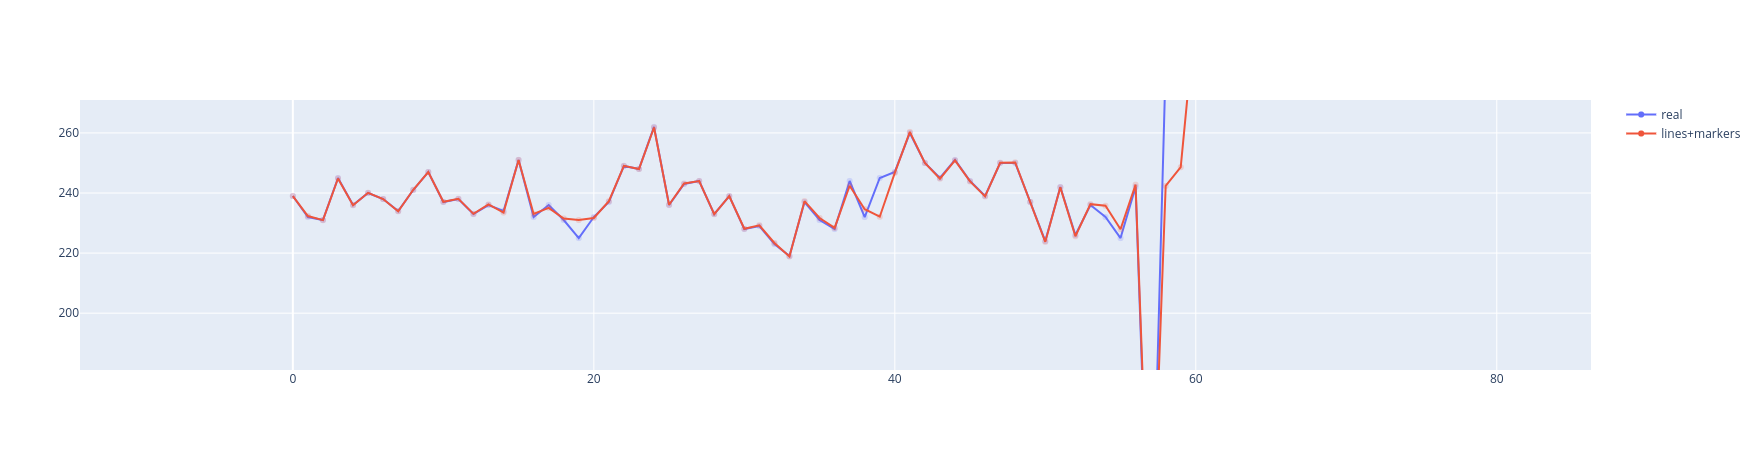

In [5]:
import plotly.graph_objects as go

# Create random data with numpy
import numpy as np
import pandas as pd

real = pd.read_csv("daco_ground_truth_1_steps_20_batch-size_3_layers.csv").values.reshape((len(real)))
bbb = pd.read_csv("daco_predictions_1_steps_20_batch-size_3_layers.csv").values.reshape((len(bbb)))

random_x =np.arange(len(bbb))

# Create traces
fig = go.Figure()
fig.add_trace(go.Scatter(x=random_x, y=real,
                    mode='lines+markers',
                    name='real'))
fig.add_trace(go.Scatter(x=random_x, y=bbb,
                    mode='lines+markers',
                    name='lines+markers'))


fig.show()